In [2]:
import numpy as np
import copy
import h5py
import matplotlib.pyplot as plt
from utils.coco_utils import load_coco_data
%matplotlib inline

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Activation, TimeDistributed, Merge
from keras.layers import Embedding, Dropout
from keras.layers import LSTM
from keras.layers.core import RepeatVector
from keras import callbacks, utils, optimizers

Using TensorFlow backend.


### Loading the data to Memory

In [3]:

data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.iteritems():
  if type(v) == np.ndarray:
    print k, type(v), v.shape, v.dtype
  else:
    print k, type(v), len(v)

idx_to_word <type 'list'> 1004
train_captions <type 'numpy.ndarray'> (400135, 17) int32
val_captions <type 'numpy.ndarray'> (195954, 17) int32
train_image_idxs <type 'numpy.ndarray'> (400135,) int32
val_features <type 'numpy.ndarray'> (40504, 512) float32
val_image_idxs <type 'numpy.ndarray'> (195954,) int32
train_features <type 'numpy.ndarray'> (82783, 512) float32
train_urls <type 'numpy.ndarray'> (82783,) |S63
val_urls <type 'numpy.ndarray'> (40504,) |S63
word_to_idx <type 'dict'> 1004


In [4]:
train_captions_mat = data['train_captions']
train_image_idxs = data['train_image_idxs']
train_features = data['train_features']
val_captions_mat = data['val_captions']
val_image_idxs = data['val_image_idxs']
val_features = data['val_features']
idx_to_word = data['idx_to_word']

In [5]:
a=  data['val_image_idxs'][3]
b = data['val_urls'][a]
b

'http://farm8.staticflickr.com/7003/6528937031_10e1ce0960_z.jpg'

In [6]:
print train_captions_mat[0]
for i in train_captions_mat[0]:
    print idx_to_word[i],

[  1   4 142 510  10 667 415 277  58   2   0   0   0   0   0   0   0]
<START> a very clean and well decorated empty bathroom <END> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL>


### Number of images to use for training and validation

In [7]:
limit1 = len(train_image_idxs)
limit2 = len(val_image_idxs)
num_train_img = limit1
num_val_img = limit2
num_train_cap = limit1
num_val_cap = limit2

### Constructng image_train and image_val

In [8]:
image_train = np.zeros((num_train_img, 512))
image_val = np.zeros((num_val_img, 512))
for i in range(num_train_img):
    index = train_image_idxs[i]
    image_train[i] = train_features[index]
    
for i in range(num_val_img):
    index = val_image_idxs[i]
    image_val[i] = val_features[index]
    

In [9]:
print image_train.shape, image_val.shape

(400135, 512) (195954, 512)


### Construct word_train and word_val

In [10]:
word_train = train_captions_mat[:num_train_cap]
word_val = val_captions_mat[:num_val_cap]
print word_train.shape, word_val.shape

(400135, 17) (195954, 17)


### Constructing one-hot ecodings for y_train, y_val

In [11]:
"""
y_train = np.zeros((num_train_img, 17, 1004))
y_val = np.zeros((num_val_img, 17, 1004))

for i in range(num_train_img):
    for j in range(17):
        y_train[i][j] = utils.to_categorical(train_captions_mat[i][j], 1004)
        
for i in range(num_val_img):
    for j in range(17):
        y_val[i][j] = utils.to_categorical(val_captions_mat[i][j], 1004)

print y_train.shape, y_val.shape
"""

'\ny_train = np.zeros((num_train_img, 17, 1004))\ny_val = np.zeros((num_val_img, 17, 1004))\n\nfor i in range(num_train_img):\n    for j in range(17):\n        y_train[i][j] = utils.to_categorical(train_captions_mat[i][j], 1004)\n        \nfor i in range(num_val_img):\n    for j in range(17):\n        y_val[i][j] = utils.to_categorical(val_captions_mat[i][j], 1004)\n\nprint y_train.shape, y_val.shape\n'

### Sparse encoding

In [12]:
print train_captions_mat[0]
print train_captions_mat.shape

[  1   4 142 510  10 667 415 277  58   2   0   0   0   0   0   0   0]
(400135, 17)


In [13]:
y_train = np.zeros((num_train_img, 17, 1))
y_val = np.zeros((num_val_img, 17, 1))
y_train.shape

(400135, 17, 1)

In [14]:
for i in range(num_train_img):
    for j in range(17):
        y_train[i][j] = train_captions_mat[i][j]
        
for i in range(num_val_img):
    for j in range(17):
        y_val[i][j] = val_captions_mat[i][j]

In [15]:
# shifting values one bit left
"""
for i in range(num_train_img):
    for j in range(16):
        y_train[i][j] = y_train[i][j+1]
    
for i in range(num_val_img):
    for j in range(16):
        y_val[i][j] = y_val[i][j+1]
""" 

'\nfor i in range(num_train_img):\n    for j in range(16):\n        y_train[i][j] = y_train[i][j+1]\n    \nfor i in range(num_val_img):\n    for j in range(16):\n        y_val[i][j] = y_val[i][j+1]\n'

In [16]:
print y_train[1000]
print train_captions_mat[1000]

[[   1.]
 [   4.]
 [ 142.]
 [  29.]
 [  58.]
 [   9.]
 [   3.]
 [ 257.]
 [  36.]
 [   2.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]
 [   0.]]
[  1   4 142  29  58   9   3 257  36   2   0   0   0   0   0   0   0]


In [17]:
print y_train.shape, y_val.shape

(400135, 17, 1) (195954, 17, 1)


In [18]:
print len(y_train[0][0])

1


### Feeding input into the model to fit sentence by sentence in a LOOP

In [22]:
# create the model
embedding_vector_length = 512
vocabulary_size = 1004
max_caption_length = 17
batch_size = 64          # one parameter update per sentence
image_vector_length = 512

# image vector
image_model = Sequential()
image_model.add(Dense(image_vector_length, input_dim=512))
image_model.add(RepeatVector(max_caption_length))

# caption vector
word_model = Sequential()
word_model.add(Embedding(input_dim=vocabulary_size, 
                    output_dim=embedding_vector_length, input_length=17))

# Merge models

model = Sequential()
model.add(Merge([image_model, word_model], mode='concat'))  # merging layers
model.add(LSTM(512, unroll=True, return_sequences=True, implementation=2, stateful=False))
model.add(Dropout(rate=0.5))
model.add(TimeDistributed(Dense(vocabulary_size)))
model.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, momentum=0.0, nesterov=False)
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()
# path to checkpoints
filepath = './checkpoints/weights-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_acc', save_best_only=True, verbose=0, mode='max')
board = callbacks.TensorBoard(log_dir='./tensorboard_logs', histogram_freq=0, write_graph=True, write_images=False)


#model_history = model.fit([image_train, word_train], y_train, verbose=2, callbacks=[checkpoint, board], 
#                validation_data=([image_val, word_val], y_val) , batch_size=batch_size, shuffle=True, epochs=300)

#score = model.evaluate([image_val, word_val], y_val, verbose=2, batch_size=batch_size)

/home/blank/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 17, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 17, 512)           3147776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 17, 1004)          515052    
_________________________________________________________________
activation_1 (Activation)    (None, 17, 1004)          0         
Total params: 4,439,532.0
Trainable params: 4,439,532.0
Non-trainable params: 0.0
_________________________________________________________________


### Loading trained model

In [23]:
model.load_weights('weights-137-0.99.hdf5')

In [86]:
index = 245
prediction = model.predict_classes([image_val[:500], word_val[:500]], verbose=2)[index]
print prediction

[  1   4  47   3   4 163  26  11   8   4 163 618   2   0   0   0   0]


### Probability of top four words at each position(pos=17)

In [100]:
prob = model.predict_proba([image_val[:500], word_val[:500]], verbose=2)[index]
print prob.shape
prob.sort()
for i in range(17):
    print prob[i][1000:]

(17, 1004)
[  4.40305030e-06   4.53565872e-06   4.99491398e-06   9.99977112e-01]
[  4.30463913e-08   1.05077305e-07   1.23386144e-07   9.99999642e-01]
[  1.05598476e-04   1.31689550e-04   7.67902879e-04   9.98216331e-01]
[  2.58037147e-07   3.73948495e-07   4.20365410e-07   9.99997020e-01]
[  4.43540742e-08   6.32923758e-08   1.76055266e-07   9.99999523e-01]
[  8.83949513e-04   9.35978664e-04   1.32639473e-03   9.91971135e-01]
[  1.25319551e-04   3.02522414e-04   3.12407530e-04   9.98321235e-01]
[  4.42405144e-06   4.71298154e-06   7.81395793e-05   9.99867678e-01]
[  9.32351213e-07   9.85939323e-07   2.39474912e-06   9.99989510e-01]
[  5.05546289e-08   6.73881431e-08   1.18503010e-07   9.99999642e-01]
[ 0.0052811   0.00585441  0.01259815  0.94527996]
[ 0.01663177  0.01826168  0.11777093  0.56316745]
[  2.21187051e-07   3.83511463e-07   5.42736643e-07   9.99997973e-01]
[  2.79024750e-08   2.84093105e-08   3.05910284e-08   9.99999881e-01]
[  4.24555502e-09   6.73292888e-09   7.55770024e-

In [77]:
actual = val_captions_mat[index]

In [78]:
def arr_to_sent(predicted, actual):
    s = []
    m = data['idx_to_word']
    for i in predicted:
        s.append(m[i])
    print " ".join(s)
    s = []
    for i in actual:
        s.append(m[i])
    print " ".join(s)

In [79]:
arr_to_sent(prediction, actual)

<START> a dog <UNK> a sheep that is in a sheep pen <END> <NULL> <NULL> <NULL> <NULL>
<START> a dog <UNK> a sheep that is in a sheep pen <END> <NULL> <NULL> <NULL> <NULL>


6329


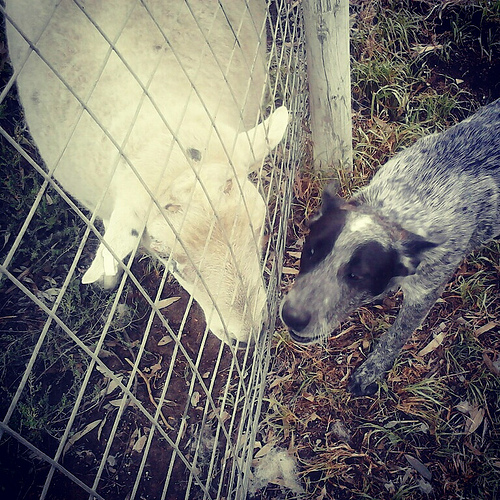

In [80]:
from IPython.display import Image, display
a = data['val_image_idxs'][index]
print a
b = data['val_urls'][a]
display(Image(b))

### Displaying all captions

In [81]:
def array_to_sentence(arr):
    s = []
    m = data['idx_to_word']
    for i in arr: 
        s.append(m[i])
    return " ".join(s)

def generate_all_captions(a):
    test = []
    for i, v in enumerate(data['val_image_idxs']):
        if v == a :
            print array_to_sentence(val_captions_mat[i])
            test.append(i)
            
    print test 

In [82]:
generate_all_captions(a)

<START> a dog and a <UNK> with their <UNK> <UNK> at fence <END> <NULL> <NULL> <NULL> <NULL>
<START> a dog <UNK> a sheep that is in a sheep pen <END> <NULL> <NULL> <NULL> <NULL>
<START> two animals get close through a fence <END> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL>
<START> a sheep and a dog <UNK> <UNK> through a fence <END> <NULL> <NULL> <NULL> <NULL> <NULL>
<START> a couple of animals that are beside a fence <END> <NULL> <NULL> <NULL> <NULL> <NULL> <NULL>
[143, 245, 280, 386, 31506]
